#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
from scipy import sparse
from scipy.linalg import block_diag
import scipy.io as spio

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

#import os.path
import os
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [11]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [12]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

#### Load Active optics relevant data

In [2]:
# Calibrations data
#dt = np.load(Path(calibDataFolder)/'calib_dt_SH0p5fluxTH_46BM.npz', allow_pickle=True)
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)

# Relative RBM:BM weighting
norm_RBM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:12])
norm_BM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,12:])
print('Ratio ||BM||/||RBM||:',norm_BM/norm_RBM)
# M1:M2 
norm_Dm1 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:6])
norm_Dm2 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,6:12])
print('Ratio ||D_m1||/||D_m2||:%0.3g'%(norm_Dm1/norm_Dm2))

Ratio ||BM||/||RBM||: 0.057479135047774646
Ratio ||D_m1||/||D_m2||:7.77


In [4]:
def get_aco_recW(Dsh,n_bm,max_m1RBM,max_m2RBM):
    
    # --- W2 ---
    _U,sigma,VT = np.linalg.svd(Dsh,full_matrices=False)
    q = 40*sigma[-12:] #np.ones((12)) #np.zeros_like(sigma)
    W2 = VT[-12:,:].T.dot(np.diag(q)).dot(VT[-12:,:])

    # --- W3 ---
    rho_bm = 10.0 #100.0

    W_M1TxyzRxyz = 1/(np.array(max_m1RBM)**2)
    W_M2TxyzRxyz = 1/(np.array(max_m2RBM)**2) #((1/4)**2)/(np.array(max_m2RBM)**2)
    W_M1TxyzRxyz[:3] = 4*W_M2TxyzRxyz[:3] #16*W_M2TxyzRxyz[:3]
    W_M2TxyzRxyz[:3] = 0.01*W_M2TxyzRxyz[:3]
    
    #W_M1TxyzRxyz = np.ones_like(W_M1TxyzRxyz)
    #W_M2TxyzRxyz = ((1/7.7)**2)*np.ones_like(W_M2TxyzRxyz)
    
    W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
    W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
    # Rescale RBM weighting matrix
    W_rbm_oa = (1/np.linalg.norm(W_rbm_oa))*W_rbm_oa
    W_rbm_cs = (1/np.linalg.norm(W_rbm_cs))*W_rbm_cs

    # OA segment weights
    W_m1oaBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
    W_m1oaBM =  rho_bm*(1/np.linalg.norm(W_m1oaBM))*W_m1oaBM
    #W_m1oaBM =  rho_bm*W_m1oaBM
    # CS (center segment) weights
    W_m1csBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
    W_m1csBM =  rho_bm*(1/np.linalg.norm(W_m1csBM))*W_m1csBM
    #W_m1csBM =  rho_bm*W_m1csBM

    W3_oa = block_diag(W_rbm_oa,W_m1oaBM)
    W3_cs = block_diag(W_rbm_cs,W_m1csBM)
    W3 = block_diag(np.kron(np.eye(6),W3_oa),W3_cs)
    #sens_D = np.linalg.norm(Dsh, axis=0)**2
    #W3 = W3.dot(np.diag(sens_D))
    
    W3 = (1/np.linalg.norm(W3))*W3
    
    return W2, W3

# def get_aco_recW(Dsh,n_bm,max_m1RBM,max_m2RBM):
    
#     # --- W2 ---
#     _U,sigma,VT = np.linalg.svd(Dsh,full_matrices=False)
#     q = 40*sigma[-12:] #np.ones((12)) #np.zeros_like(sigma)
#     W2 = VT[-12:,:].T.dot(np.diag(q)).dot(VT[-12:,:])

#     # --- W3 ---
#     rho_bm = 1.0 #0.1

#     W_M1TxyzRxyz = 1/np.array(max_m1RBM)
#     W_M2TxyzRxyz = 0.1/np.array(max_m2RBM)    
#     W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
#     W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
#     # Rescale RBM weighting matrix
#     W_rbm_oa = (1/np.linalg.norm(W_rbm_oa))*W_rbm_oa
#     W_rbm_cs = (1/np.linalg.norm(W_rbm_cs))*W_rbm_cs

#     # OA segment weights
#     W_m1oaBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
#     W_m1oaBM =  rho_bm*(1/np.linalg.norm(W_m1oaBM))*W_m1oaBM
#     # CS (center segment) weights
#     W_m1csBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
#     W_m1csBM =  rho_bm*(1/np.linalg.norm(W_m1csBM))*W_m1csBM

#     W3_oa = block_diag(W_rbm_oa,W_m1oaBM)
#     W3_cs = block_diag(W_rbm_cs,W_m1csBM)
#     W3 = block_diag(np.kron(np.eye(6),W3_oa),W3_cs)
#     sens_D = np.linalg.norm(Dsh, axis=0)**2
#     W3 = W3.dot(np.diag(sens_D))
#     W3 = (1/np.linalg.norm(W3))*W3
    
#     return W2, W3



#### AcO reconstructor+controller settings

In [5]:
# *** Reconstructor tuning settings ***

# Number of bending modes
n_bm = 27

# Consolidate SH-WFS interaction matrices of all segments
Dsh = block_diag(*[Dseg[:,:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dsh = block_diag(Dsh,dt['calibdt'][()]['D'][-1][:,:10+n_bm])

# Max actuator command values
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
max_m2RBM = [3.0e-5,3.0e-5,3.0e-5] + [3.5e-3,3.5e-3,3.5e-3]
W2,W3 = get_aco_recW(Dsh,n_bm,max_m1RBM,max_m2RBM)

max_Fz = 147
K, rho_2, rho_3 = 0.25, 1.0, 1.0

# Print reconstructor regularization weights
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
w__, _w_,__w = np.split(np.diag(W3),[12,39])
print('OA BM weights:\n',_w_)
print('M1/2 RBM weights (M1/TxyzRxyz - M2/TxyzRxyz):\n',w__)
np.set_printoptions(formatter=None)


# *** Controller settings ****

# Plant dynamic model matrices
A = np.zeros((84+7*n_bm,84+7*n_bm))
B = np.identity(84+7*n_bm)
nx, nu = A.shape[0], B.shape[1]

# Prediction horizon
npred = 4
# Weighting matrices
Q = np.eye(nx)
R = 8*np.kron(np.eye(7),block_diag(np.diag(np.array([1]*6)),
                                   np.diag(np.array([1]*6)),
                                   np.diag(np.array([1]*n_bm))))
print(np.linalg.norm(Q),np.linalg.norm(R))

# Bending modes' data
Afz = {}

# OA segment weights
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])

rbm_ranges = max_m1RBM+max_m2RBM
#oa_ranges = np.array(rbm_ranges + [max_Fz/np.linalg.norm(bm2Fz_oa)]*bm2Fz_oa.shape[0])
#cs_ranges = np.array(rbm_ranges + [max_Fz/np.linalg.norm(bm2Fz_cs)]*bm2Fz_cs.shape[0])
oa_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_oa.shape[0])
cs_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_cs.shape[0])

umax = np.hstack([np.kron(np.array([1]*6),oa_ranges),cs_ranges]) # np.array([]) #
umin = -umax
_Tu = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),bm2Fz_oa)),
                 block_diag(np.eye(12),bm2Fz_cs))

# AcO dictionary
data = {'SHAcO':{'D':Dsh,'n_bm':n_bm,'W2':W2,'W3':W3,
                 'K':K,'rho_2':rho_2,'rho_3':rho_3,
                 'wfsMask':dt['calibdt'][()]['wfsMask'],
                 'A':A,'B':B,
                 'Q':sparse.csc_matrix(Q),'R':sparse.csc_matrix(R),'npred':npred,
                 'umin':umin, 'umax':umax,'_Tu':_Tu,'J1_J3_ratio':20}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO.pickle','wb') as f:
    pickle.dump(data,f)
    

OA BM weights:
 [ 0.072378  0.072378  0.072378  0.072378  0.072378  0.072378  0.072378
  0.072378  0.072378  0.072378  0.072378  0.072378  0.072378  0.072378
  0.072378  0.072378  0.072378  0.072378  0.072378  0.072378  0.072378
  0.072378  0.072378  0.072378  0.072378  0.072378  0.072378]
M1/2 RBM weights (M1/TxyzRxyz - M2/TxyzRxyz):
 [ 0.021713  0.021713  0.021713  0.000012  0.000015  0.000015  0.000054
  0.000054  0.000054  0.000000  0.000000  0.000000]
16.522711641858304 132.18169313486644


In [6]:
# # Check reconstructors 
# M_rls = dos.tools.build_RLS_RecM(Dsh, W2, W3=1.0e-3*W3, K=K, rho_2=np.sqrt(1), rho_3=rho_3, insM1M2S7Rz=True)
# M_rls = M_rls[:,:-273]
# M_tsvd = dos.tools.build_TSVD_RecM(Dsh, n_r=12, insM1M2S7Rz=True)
# M = dos.tools.build_AcO_Rec(dt['calibdt'][()]['D'],n_bm=n_bm,rec_alg='TSVD')
# print(np.linalg.norm(M_rls-M), np.linalg.norm(M_tsvd-M))

# dt1 = np.diag(M_rls.dot(M_rls.T))[:39]
# dt2 = np.diag(M_tsvd.dot(M_tsvd.T))[:39]
# dt3 = np.diag(M.dot(M.T))[:39]
# plt.figure(figsize=(16,6))
# #plt.plot(100*np.abs(dt3-dt1)/dt3,'s')
# #plt.plot(100*np.abs(dt3-dt2)/dt3,'+')
# plt.semilogy(dt1,'s')
# plt.semilogy(dt2,'.')
# plt.semilogy(dt3,'x')

#### Set initial M1/M2 states and generate respective yaml files

In [7]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML

# ----- Flag to control if simulation initial state is updated -----
updateX0 = False

test_case = 'BM_dist' #'random_RBM' #

# Initialize states dictionary
if 'm1_x0_dt' not in locals():
    m1_x0_dt = {'mirror' : 'M1',
                'mirror_args': {'mirror_modes': 'bending modes','N_MODE': n_bm},
                'state': {'Txyz':[],'Rxyz':[],'modes':[]}}
if 'm2_x0_dt' not in locals():
    m2_x0_dt = {'mirror' : 'M2',
                'mirror_args': {},
                'state': {'Txyz':[],'Rxyz':[]}}

m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()        
# Update number of M1 bending modes in yaml file
m1_x0_dt['mirror_args']['N_MODE'] = n_bm
        
if(test_case == 'fully_aligned'):
    pass

#        
elif(test_case == 'BM_dist'):
    m1_x0_dt['state']['modes'][0][2] = 5.0e-4
    m1_x0_dt['state']['modes'][0][1] = 5.0e-4
    
#    
elif(test_case == 'random_RBM') and updateX0:
    k_ = 3.0e-6    # 3xstd
    as2urad = 4.84814
    x_rand = (2*np.random.rand(7,39)-1)
    # M1 random initial values
    x0_M1_Tx = k_*block_diag(np.kron(np.eye(6),0.057),1.654).dot(x_rand[:,0])
    x0_M1_Ty = k_*block_diag(np.kron(np.eye(6),0.06),0.99).dot(x_rand[:,1])
    x0_M1_Tz = k_*block_diag(np.kron(np.eye(6),0.144),0.201).dot(x_rand[:,2])
    m1_x0_dt['state']['Txyz'] = np.vstack([x0_M1_Tx,x0_M1_Ty,x0_M1_Tz]).T.tolist()
    x0_M1_Rx = k_*as2urad*block_diag(np.kron(np.eye(6),0.01),0.014).dot(x_rand[:,3])
    x0_M1_Ry = k_*as2urad*block_diag(np.kron(np.eye(6),0.004),0.016).dot(x_rand[:,4])
    x0_M1_Rz = k_*as2urad*block_diag(np.kron(np.eye(6),0.006),0.035).dot(x_rand[:,5])
    m1_x0_dt['state']['Rxyz'] = np.vstack([x0_M1_Rx,x0_M1_Ry,x0_M1_Rz]).T.tolist()
    #x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)
    # M2 random initial values
    x0_M2_Tx = k_*block_diag(np.kron(np.eye(6),6.235),5.863).dot(x_rand[:,6])
    x0_M2_Ty = k_*block_diag(np.kron(np.eye(6),6.192),5.863).dot(x_rand[:,7])
    x0_M2_Tz = k_*block_diag(np.kron(np.eye(6),1.595),0.869).dot(x_rand[:,8])
    m2_x0_dt['state']['Txyz'] = np.vstack([x0_M2_Tx,x0_M2_Ty,x0_M2_Tz]).T.tolist()
    x0_M2_Rx = k_*as2urad*block_diag(np.kron(np.eye(6),0.474),0.463).dot(x_rand[:,9])
    x0_M2_Ry = k_*as2urad*block_diag(np.kron(np.eye(6),0.688),0.465).dot(x_rand[:,10])
    x0_M2_Rz = k_*as2urad*block_diag(np.kron(np.eye(6),2.315),2.186).dot(x_rand[:,11])
    m2_x0_dt['state']['Rxyz'] = np.vstack([x0_M2_Rx,x0_M2_Ry,x0_M2_Rz]).T.tolist()

if updateX0:
    # Update yaml files with M1/M2 initial conditions    
    with open(Path(sim_folder)/'M1.yaml','w') as f:
            y.dump(m1_x0_dt, f)
    with open(Path(sim_folder)/'M2.yaml','w') as f:
            y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

In [8]:
sim = dos.DOS(sim_folder,verbose=logging.WARNING,show_timing=2)

INFO:wfs48 data:Linked to data from wfs48
INFO:M1 Txyz:Linked to Txyz from M1
INFO:M1 Rxyz:Linked to Rxyz from M1
INFO:M2 Txyz:Linked to Txyz from M2
INFO:M2 Rxyz:Linked to Rxyz from M2
INFO:M1 BM:Linked to modes from M1


SIMCEO server received: Acknowledging connection from SIMCEO client!
Absolute constraints introduced to the MPC


In [25]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
#np.set_printoptions(formatter=None)

#### Instantiate DOS

In [9]:
# Start simulation
#sim.start()
sim._run_()

-> J1:1.66e-09, J3:1.67e-10, ratio:9.91, ||s||:1.16e-08
Number of regularization iterations:6
+> J1:1.7e-09 J1/(rho_3*J3):7.42

-> J1:1.68e-09, J3:6.42e-10, ratio:5.27, ||s||:1.16e-08
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [11  0  0  0  0  0  0]
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [14  0  0  0  0  0  0]
Number of regularization iterations:4
+> J1:5.16e-09 J1/(rho_3*J3):1.12

-> J1:1.02e-09, J3:8.56e-10, ratio:9.13, ||s||:1.1e-08
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [19  0  0  0  0  0  0]
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [28  0  0  0  0  0  0]
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [2 0 0 0 0 0 0]
Number of regularization iterations:4
+> J1:7.95e-09 J1/(rho_3*J3):2.01

-> J1:5.2e-10, J3:9.29e-10, ratio:9.38, ||s||:1.12e-08
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [2 0 0 0 0 0 0]
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [2 0 0 0 0 0 0]
[1.1 0.  0.  0.  0.  0.  0. ]
u_sat_mask_bm_sum [2 0 0 0 0 0 0]
[1.1 0.  0.  0.  0. 

In [83]:
sim.pctComplete

100

### Image quality metrics

In [ ]:
sim.logs

In [ ]:
print(sim.logs.entries['science']['wfe_rms'].timeSeries[1][0,:]*1.0e9)
print('Seg WFE RMS:\n',sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]*1.0e9)

 #### GS=6 : (Random) RBM load test - baseline reconstructor

In [ ]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 6 : (Random) RBM load test


Final values:
 WFE (nm): [10.31894392] 
 [0.77535456 0.76835011 0.76279022 0.7695764  0.77929369 0.76557366
 0.18641699] 
PSSn: [0.99999996] 
sum of abs seg piston (um): 0.05275379452718276 
 [ 0.01995812 -0.00242824 -0.00037869  0.00309666  0.00108423 -0.01088716
 -0.0149207 ]


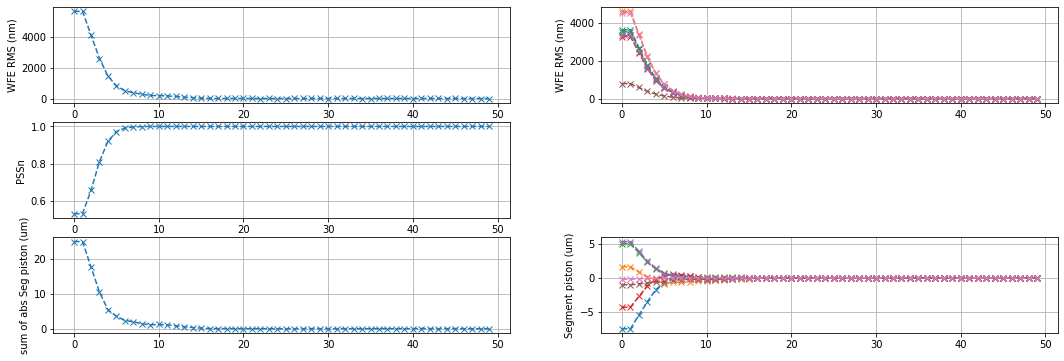

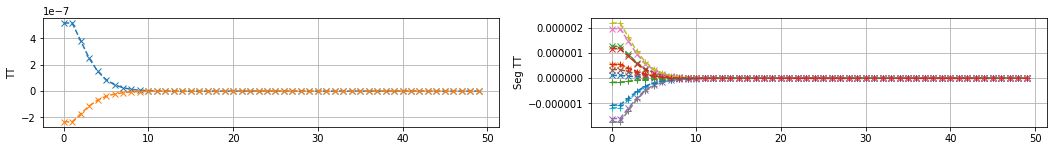

In [10]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 6 : Bending mode load test


Final values:
 WFE (nm): [42642.46672392] 
 [1.11370100e+05 7.67162001e-01 7.68458297e-01 7.72417130e-01
 7.76703868e-01 7.70461139e-01 1.72909603e-01] 
PSSn: [0.8040299] 
sum of abs seg piston (um): 11.694124570180154 
 [ 1.16926676e+01 -2.14939663e-04 -2.36568598e-04 -1.90832128e-04
 -2.12767998e-04 -2.05867989e-04  3.95980998e-04]


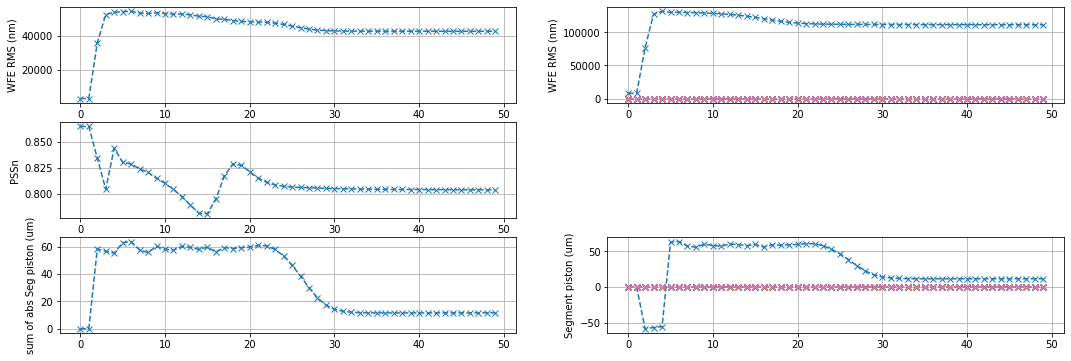

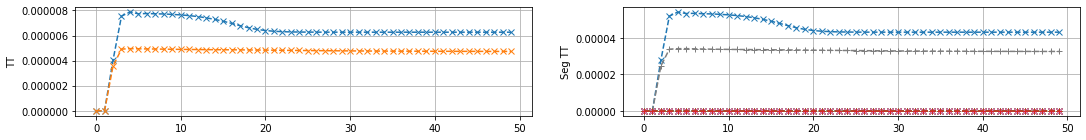

In [31]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [ 9.16] 
 [ 0.76  0.77  0.78  0.78  0.78  0.76  0.17] 
PSSn: [ 1.00] 
sum of abs seg piston (um): 0.05665520763642462 
 [ 0.01 -0.00  0.00  0.01  0.00 -0.01 -0.01]


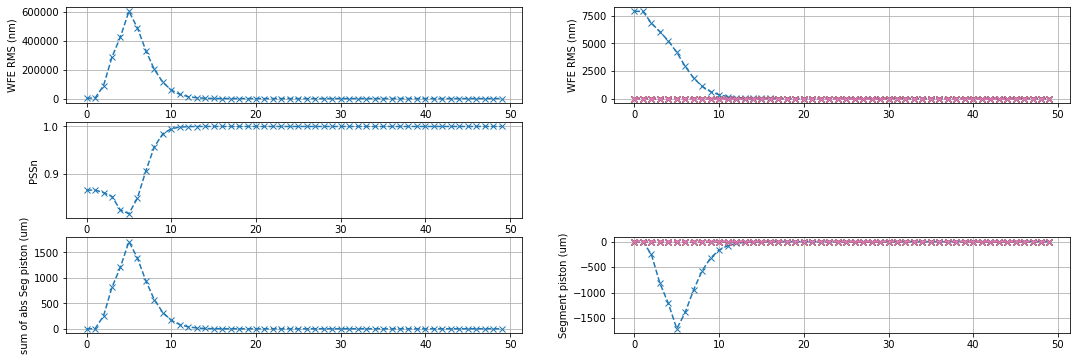

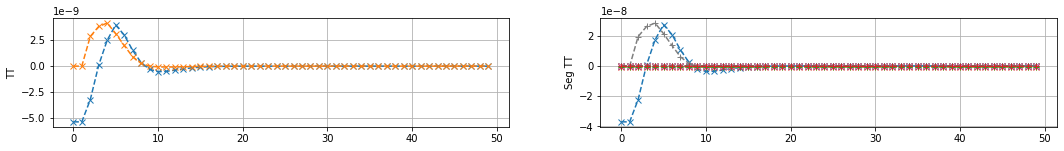

In [10]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 14: (Random) RBM load test


Final values:
 WFE (nm): [41.15151242] 
 [0.76518802 0.79881712 0.665975   0.84102636 0.84260415 0.75568146
 0.89215302] 
PSSn: [1.00003499] 
sum of abs seg piston (um): 0.27104815547573935 
 [ 0.0512833   0.05955424 -0.01292165 -0.03190981  0.05012235 -0.04093188
 -0.02432492]


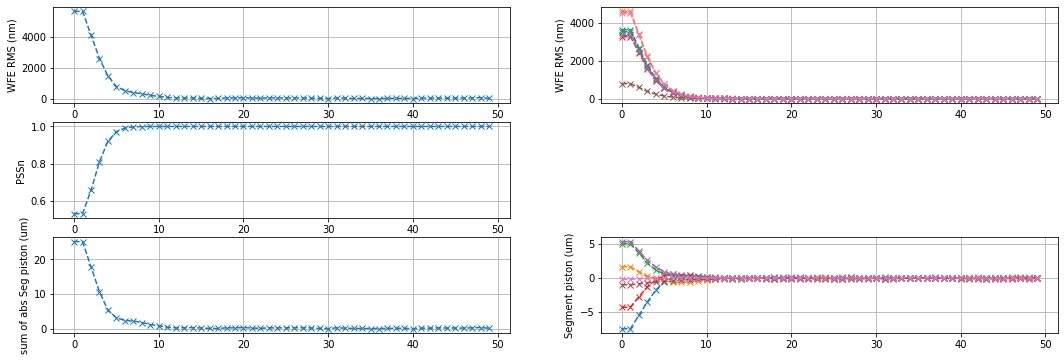

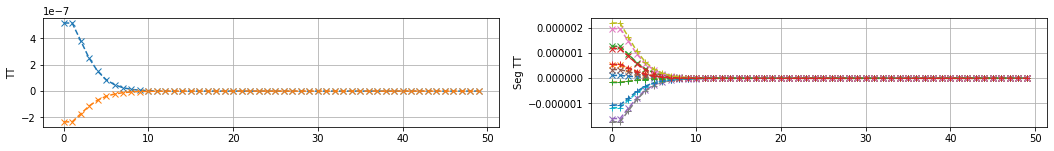

In [14]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 14 : Bending mode load test


Final values:
 WFE (nm): [60237.38751537] 
 [1.48371386e+05 7.22453319e-01 5.50377743e-01 7.95521871e-01
 9.28334132e-01 6.37614628e-01 5.44017664e-01] 
PSSn: [0.811321] 
sum of abs seg piston (um): 58.99602117721836 
 [ 5.89684896e+01 -2.84385493e-03  8.87629553e-05 -7.26059124e-03
  1.56620334e-02  2.91572821e-04 -1.38475054e-03]


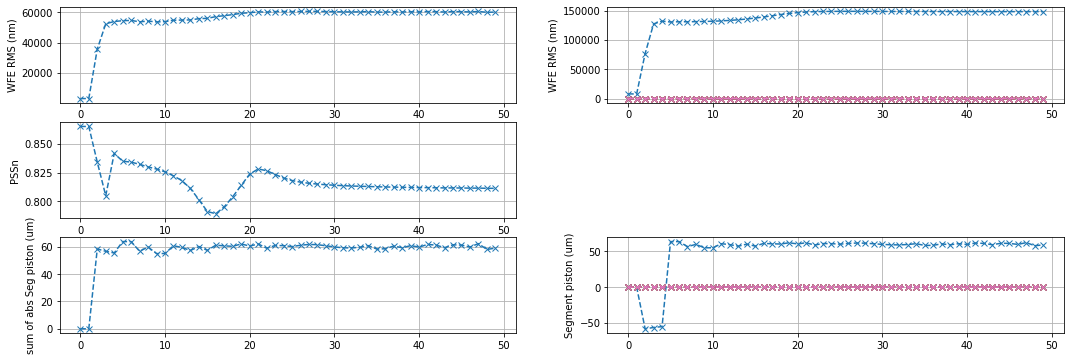

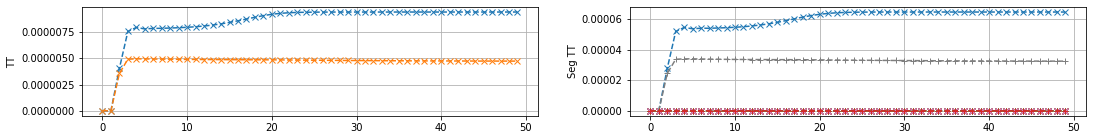

In [21]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [ 3677.00] 
 [ 2034.54  1587.30  0.51  0.95  0.98  171.88  3446.80] 
PSSn: [ 0.85] 
sum of abs seg piston (um): 14.657048126309746 
 [ 5.84 -6.36 -0.34  0.50  0.81  0.52 -0.29]


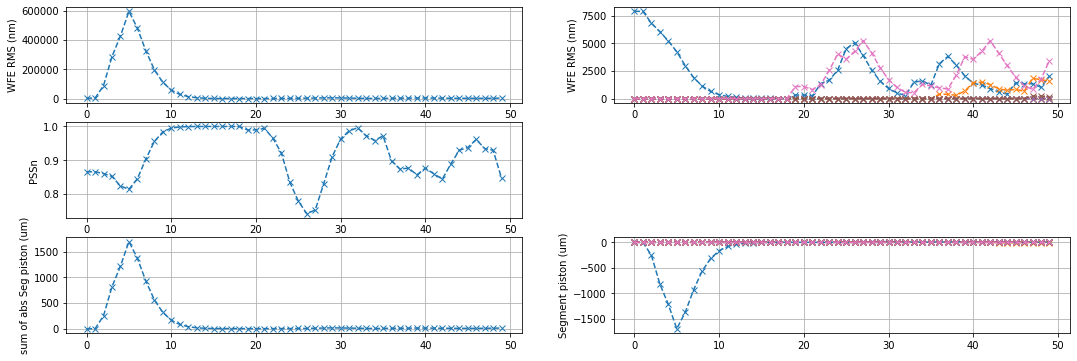

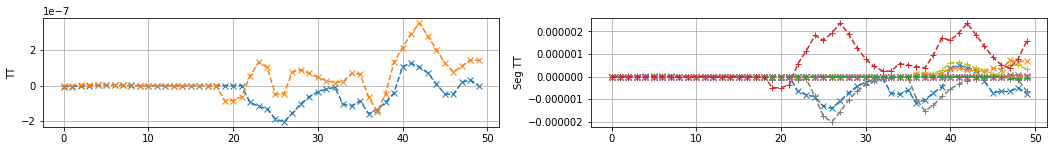

In [10]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

### Controller outputs and aberration inducing loads

#### GS = 6 : (Random) RBM load test

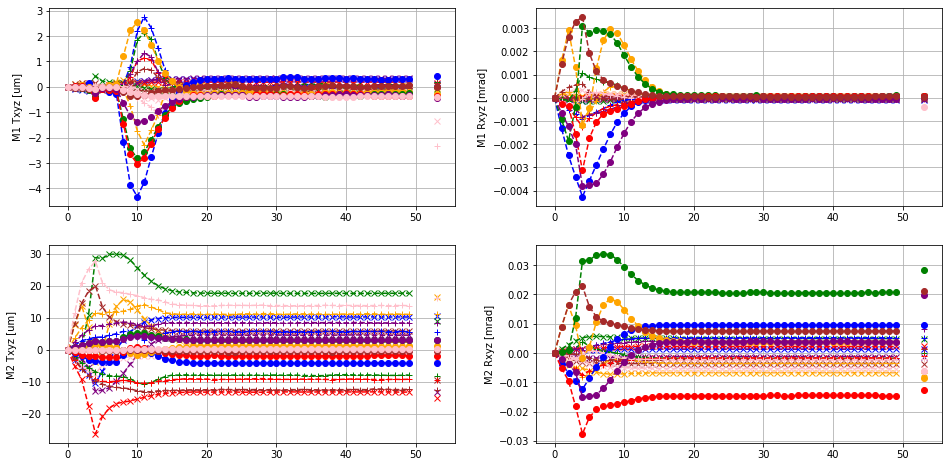

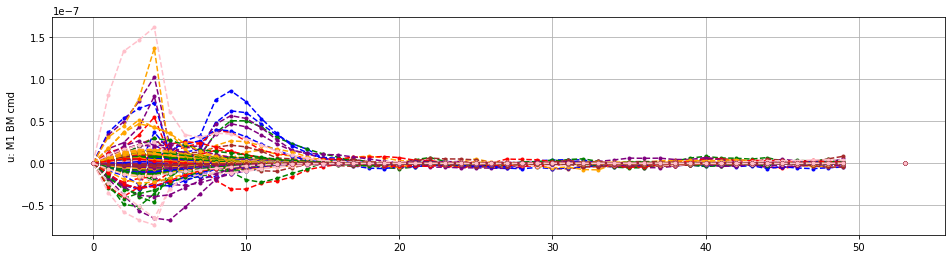

In [11]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### GS = 6 : Bending mode load test

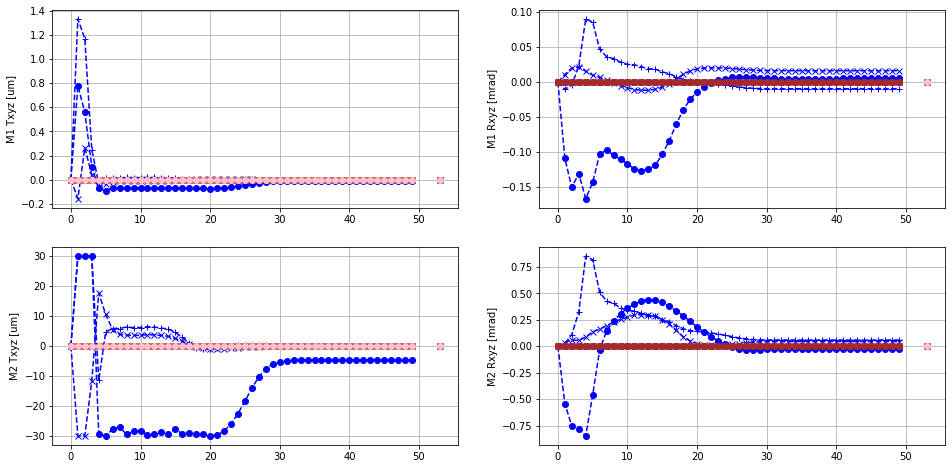

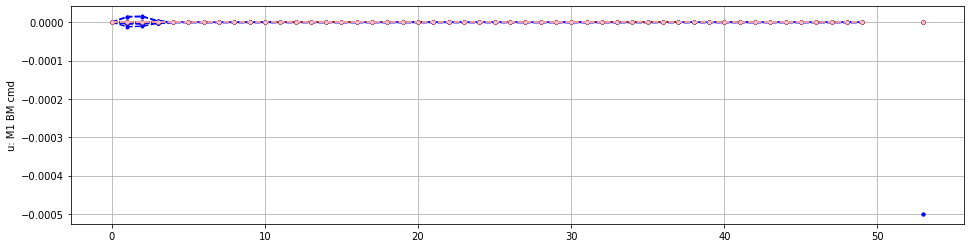

In [32]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

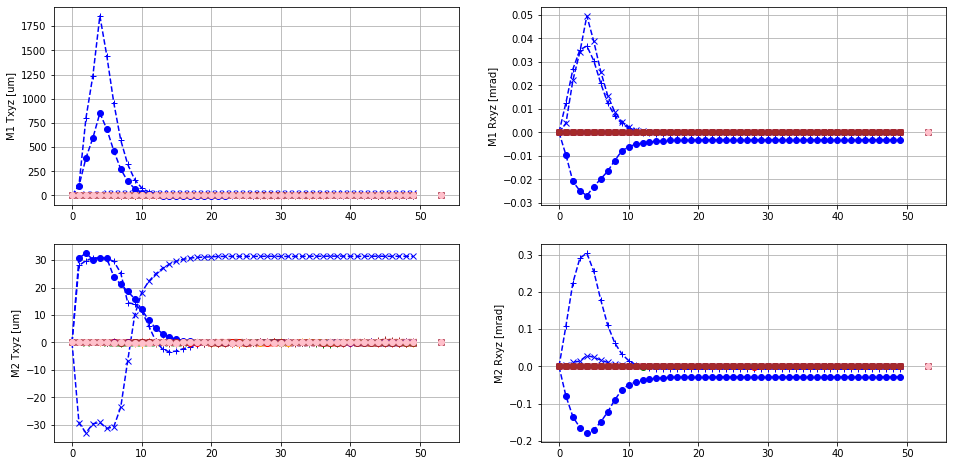

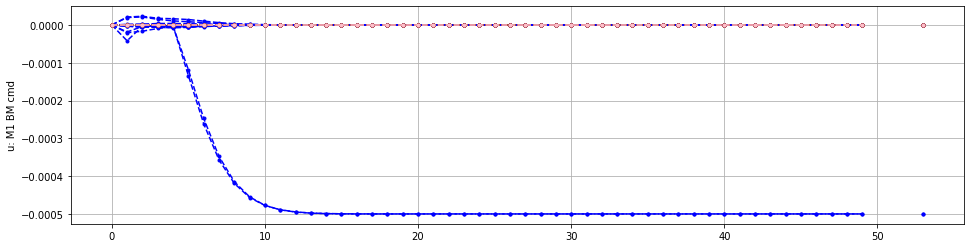

In [10]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### GS = 14 : (Random) RBM load test

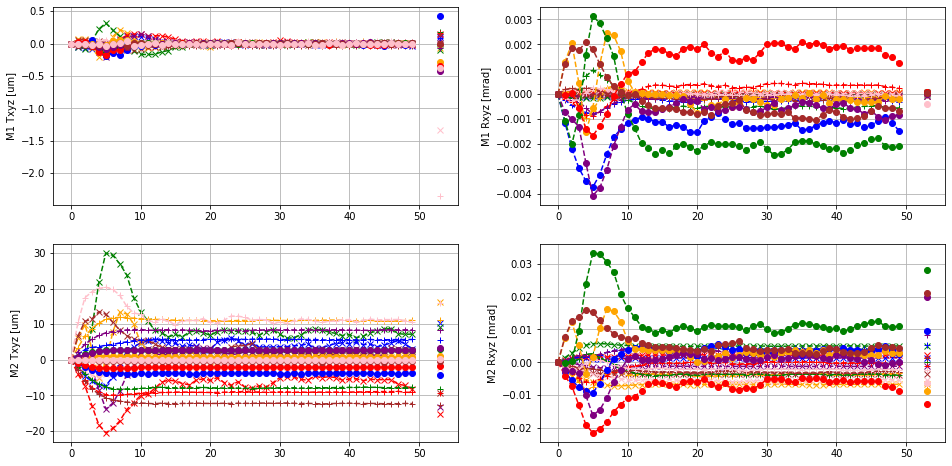

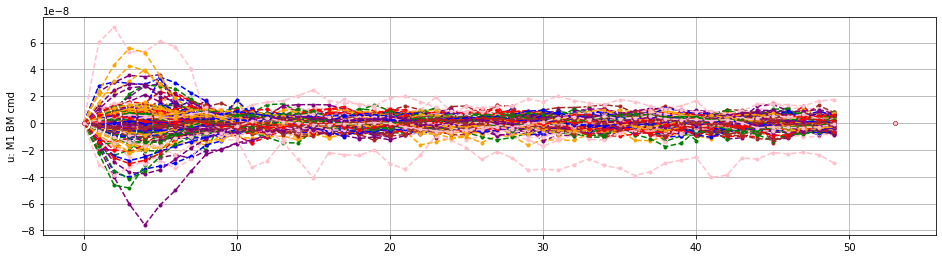

In [15]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### GS = 14 : Bending mode load test

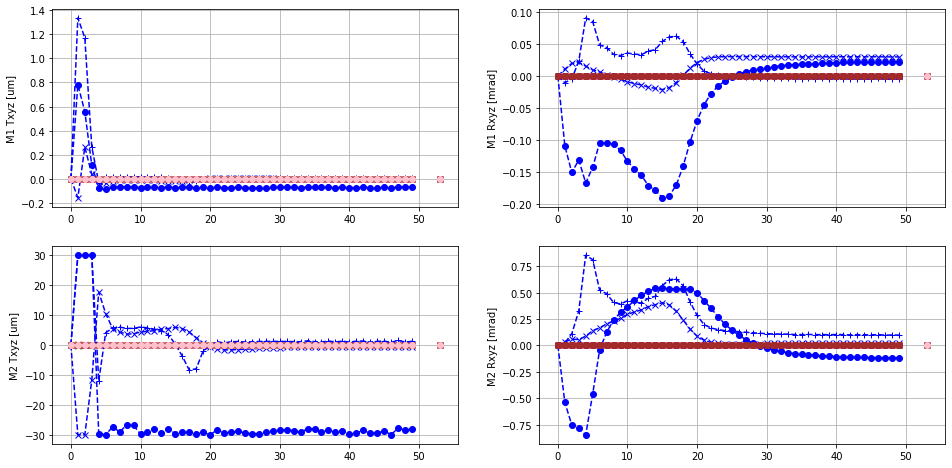

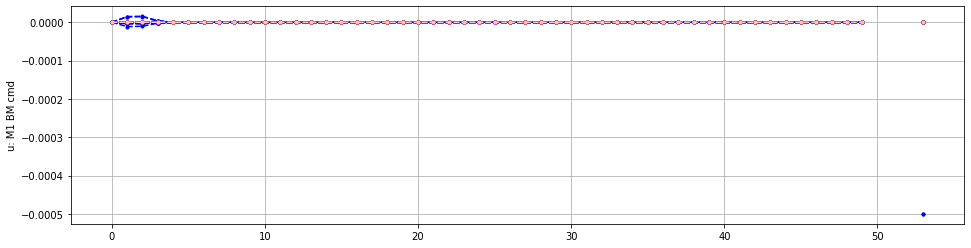

In [20]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

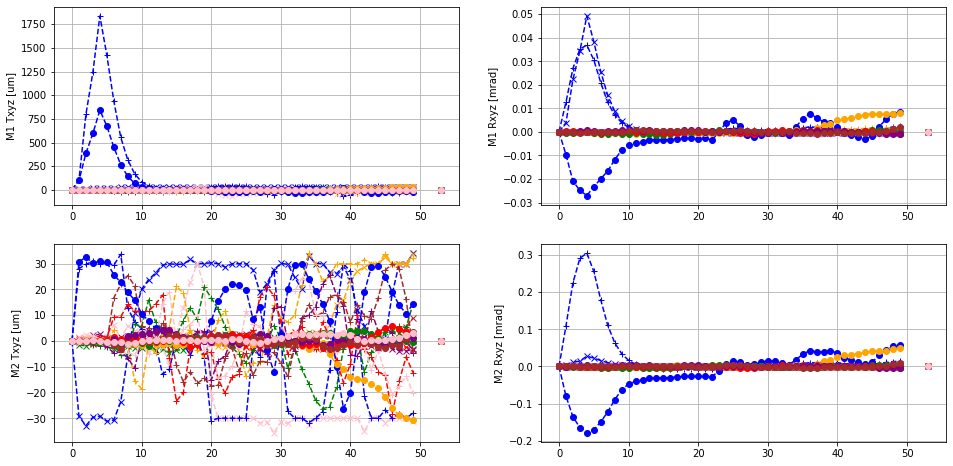

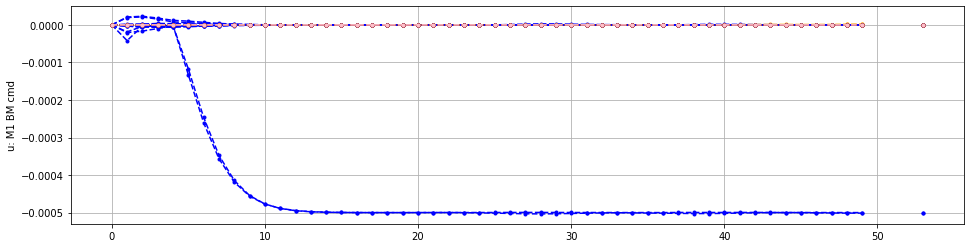

In [14]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### Baseline reconstructor with saturation $k_i=0.25$ (without noise)

In [ ]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [ ]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

In [ ]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [ ]:
3.5e-6*(180/np.pi)*3600

In [ ]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

In [ ]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

### Actuator force test

#### GS = 6 : Bending mode load test

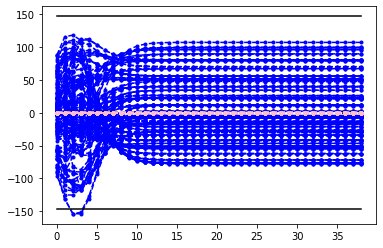

In [11]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
k_max = 40

for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,1:k_max]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,1:k_max]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.show()

#### GS = 14 : Bending mode load test

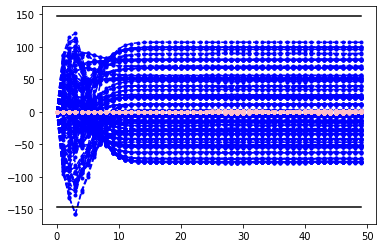

In [15]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

In [ ]:
#U_sat.shape, Fz2bm.shape, bm_sat.shape
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
isigma = np.zeros_like(s_oa)
n_bm = 27
isigma[:n_bm] = 1/s_oa[:n_bm]

T1 = np.dot(V_oaT.T, np.diag(isigma))
T2 = np.dot(np.diag(s_oa),V_oaT)
print('norm of I-T1*T2: %0.4g'%np.linalg.norm(np.eye(165)-T1.dot(T2)))

U_ = bm2Fz_oa.dot(BM_[1][0,:,4])
U_sat = np.clip(U_, -np.array([max_Fz]*bm2Fz_oa.shape[0]), np.array([max_Fz]*bm2Fz_oa.shape[0]))
bm_sat = T2.dot(U_sat)
bm_sat_reg = np.zeros_like(s_oa)
bm_sat_reg[:n_bm] = bm_sat[:n_bm]
max(U_sat), max(U_), max(T1.dot(bm_sat))

In [ ]:
plt.semilogy(np.abs(bm_sat),'.')
plt.semilogy(np.abs(bm_sat_reg),'x')

#### GS = 0 : Bending mode load test


Final values:
 WFE (nm): [ 1.26158] 
 [ 0.76287  0.77168  0.77183  0.77286  0.77268  0.77119  0.17258] 
PSSn: [ 0.99996] 
sum of abs seg piston (um): 0.005428296610821004 
 [-0.00302 -0.00063  0.00004  0.00039 -0.00029 -0.00067 -0.00039]


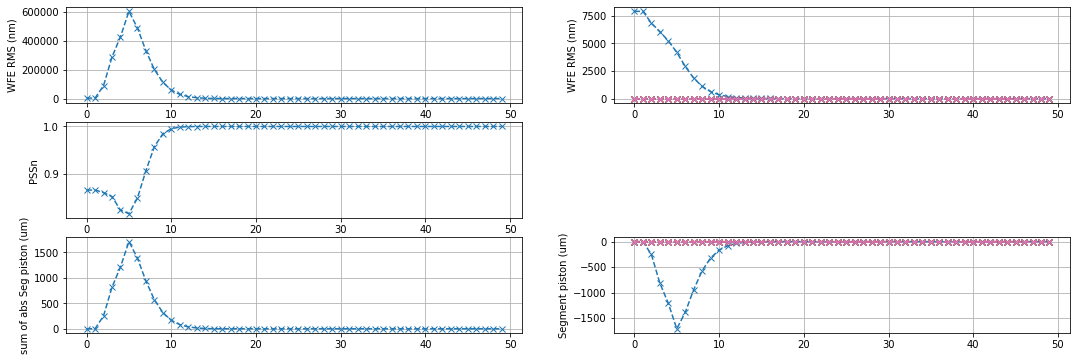

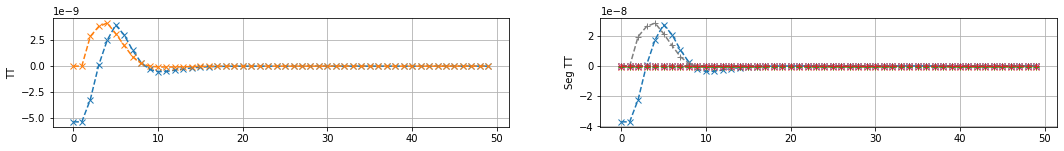

In [22]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

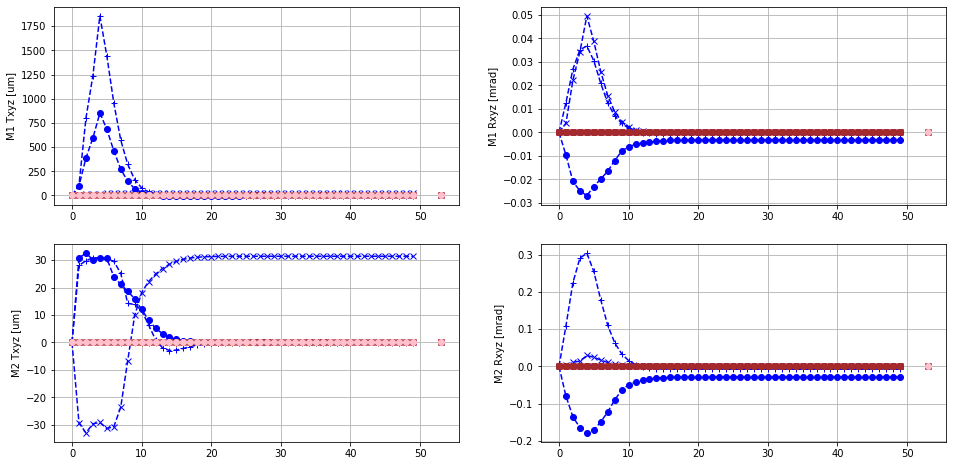

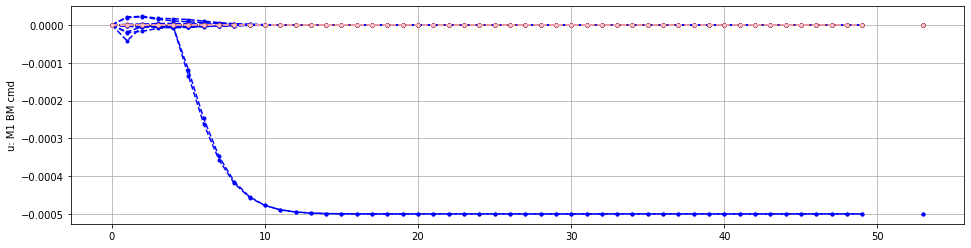

In [23]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### GSH


Final values:
 WFE (nm): [ 0.75922] 
 [ 0.77191  0.77174  0.77174  0.77191  0.77174  0.77174  0.17243] 
PSSn: [ 1.00000] 
sum of abs seg piston (um): 0.0017888417414013702 
 [-0.00022 -0.00022 -0.00022 -0.00022 -0.00022 -0.00022  0.00047]


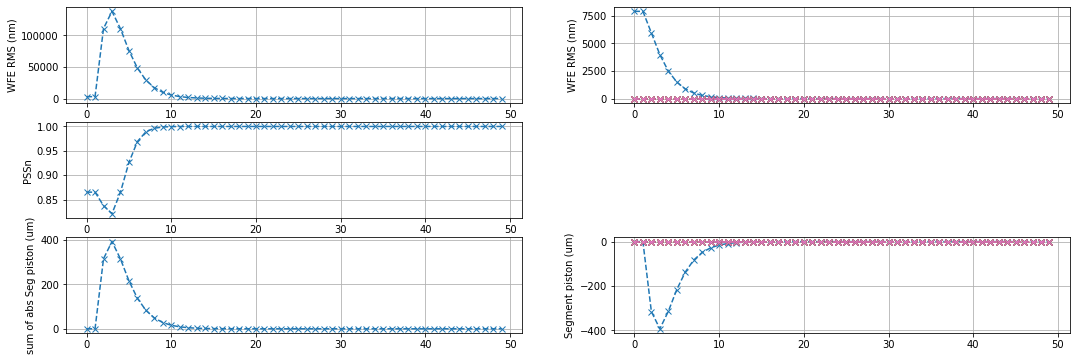

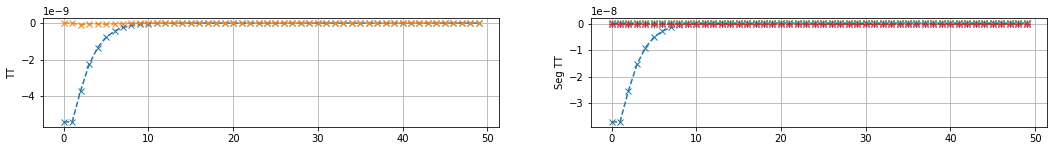

In [27]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

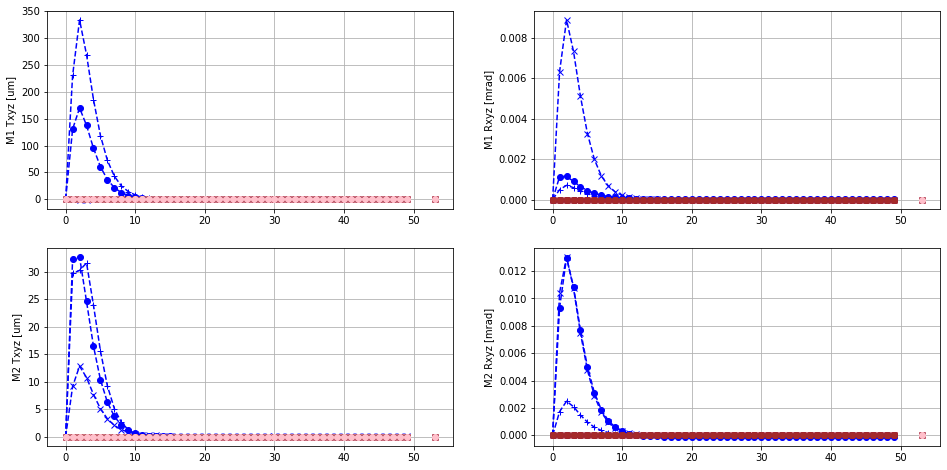

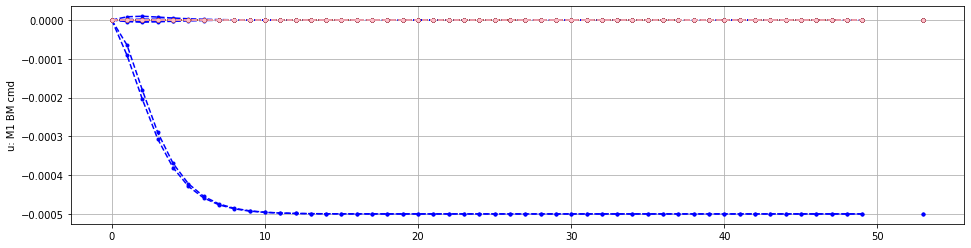

In [28]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)


Final values:
 WFE (nm): [685.01714168] 
 [1.4256526  0.5963276  0.51286725 0.94591757 1.02266284 0.40258957
 0.73158252] 
PSSn: [0.99999981] 
sum of abs seg piston (um): 4.557642000690976 
 [ 0.6470172  -1.05366144 -0.32891748  0.48825217  0.87936388  0.81835407
 -0.34207577]


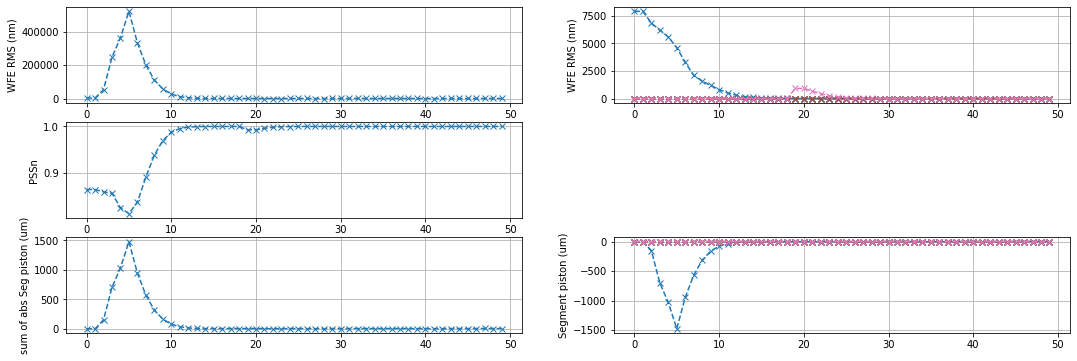

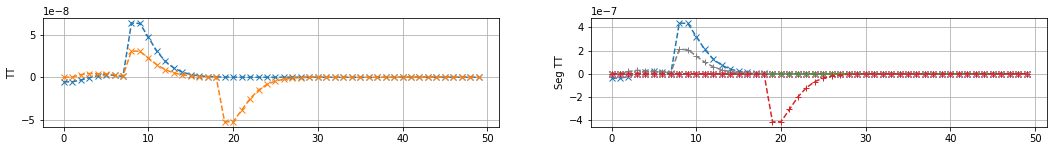

In [10]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

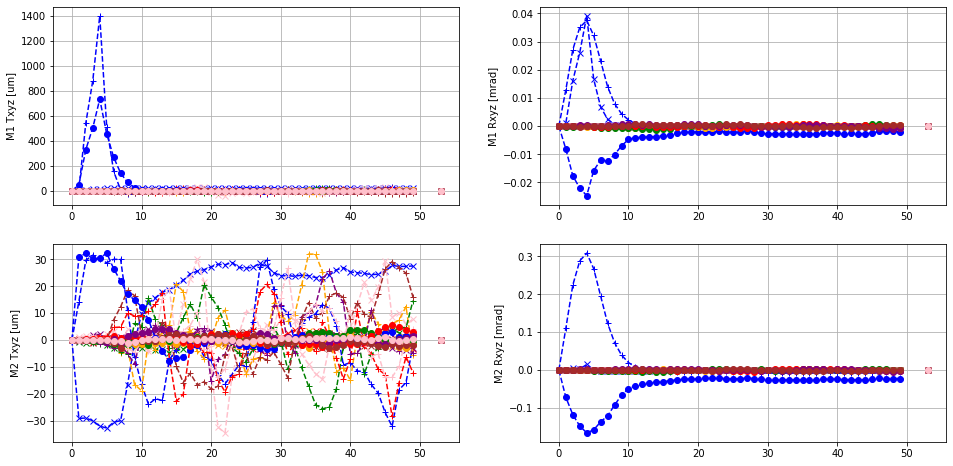

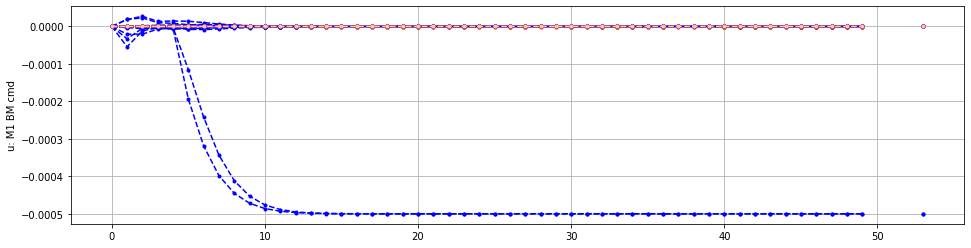

In [11]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

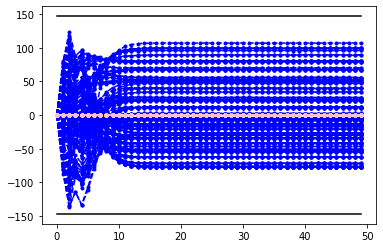

In [12]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()